# Setting IMAGINE to do the fitting

I will use this notebook for testing each of the components needed to set up IMAGINE to fit the model to the SNR data.

In [1]:
import os, sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import imagine as img
# IMAGINE extension package
import imagine_snrs as img_snrs
import shell

## Datasets/Measurements

The first step is including the observational data in IMAGINE. I've added a `datasets` module to the directory `imagine_snrs`, which contains three IMAGINE [dataset](https://imagine-code.readthedocs.io/en/latest/components.html#datasets) classes (for Stokes I, U and Q). These new classes load the fits files, extracting coordinate information and adjust to the internal format. 

This assumes that the following files are available in the present repository:

* data/I_DA530.fits
* data/Q_DA530.fits
* data/U_DA530.fits


Here is an example of how to access one of these dataset objects:

In [2]:
dset = img_snrs.datasets.SNR_DA530_I()
dset.object_id

'SNR G093.3+06.9'

In practice, we would like to load them onto [Measurements](https://imagine-code.readthedocs.io/en/latest/components.html#observables-and-observable-dictionaries) objects (which hold a set of observational datasets).
This is done in the cell below. For convenience, the `Measurements` contain a `show` method, which allows quick inspection:

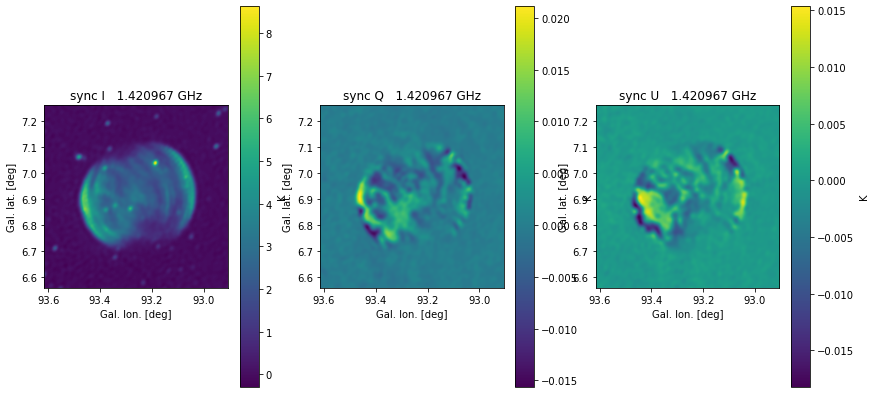

In [3]:
measurements = img.observables.Measurements(img_snrs.datasets.SNR_DA530_I(),
                                            img_snrs.datasets.SNR_DA530_Q(),
                                            img_snrs.datasets.SNR_DA530_U())
plt.figure(figsize=(14,7))
measurements.show()

## Fields

The next step is expressing our models for each of the shell components (magnetic field, thermal electron density, and cosmic ray electron density) as IMAGINE [Fields](https://imagine-code.readthedocs.io/en/latest/components.html#fields) (tutorial [here](https://imagine-code.readthedocs.io/en/latest/tutorial_fields.html)).

For definiteness, let us start by defining a grid:

In [4]:
L = 70*u.pc; N = 150
grid = img.fields.UniformGrid(# coordinate values for edges of the grid box
                              box=[[-L,L],[-L,L],[-L,L]], 
                              # Grid resolution
                              resolution=[N, N, N])

### Electron distribution 

Each of the physical components (magnetic field, thermal electron density, cosmic ray electron density) needs to be represented by a different IMAGINE Field object. I have implemented these in the `imagine_snrs.fields` module. The properties of the shell are set up inside the `SupernovaShellThermalElectrons`, and the other components will use the same setup (and depend on `SupernovaShellThermalElectrons` to re-use the same `FieldTransformer` object).

Below, I exemplify/test the `SupernovaShellThermalElectrons` class.

CPU times: user 574 ms, sys: 40.1 ms, total: 614 ms
Wall time: 614 ms


../shell/visualization.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im_slice.value, **kwargs)


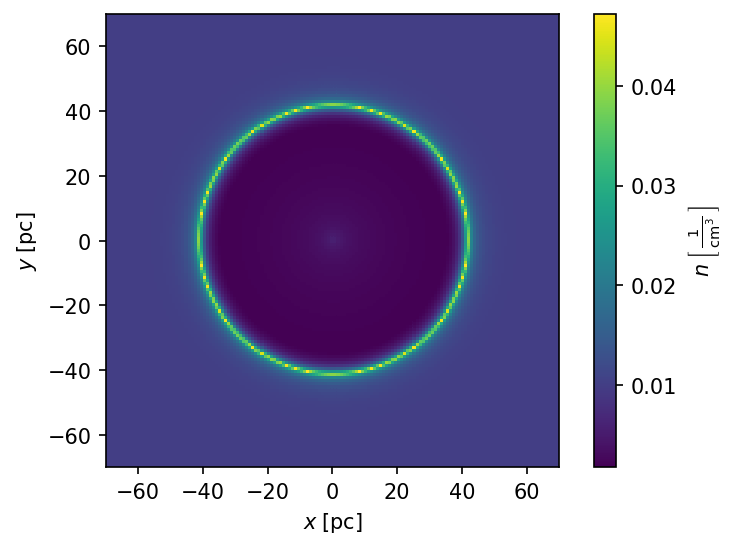

In [5]:
# Parameters dictionary, including shell parameters
parameters = {'initial_electron_density': 0.01*u.cm**-3,
              'shell_V0':0.0153*u.pc/u.yr, 
              'shell_a': 1.3, 
              'shell_b': 10,
              'elapsed_time': 1300*u.yr,
              'shell_radius': 35*u.pc}

# Creates the IMAGINE Field object
ne_field = img_snrs.fields.SNRThermalElectrons(grid, parameters=parameters)

# Evaluates the field
%time ne_data = ne_field.get_data()

# Plots the result (using previous visualization routine)
shell.visualization.plot_scalar_xy(grid, ne_data);

### Magnetic field

There are two implemented IMAGINE MagneticField subclasses: `SupernovaShellHelicalMagneticField` and `SupernovaShellUniformMagneticField`. They are exemplified below:

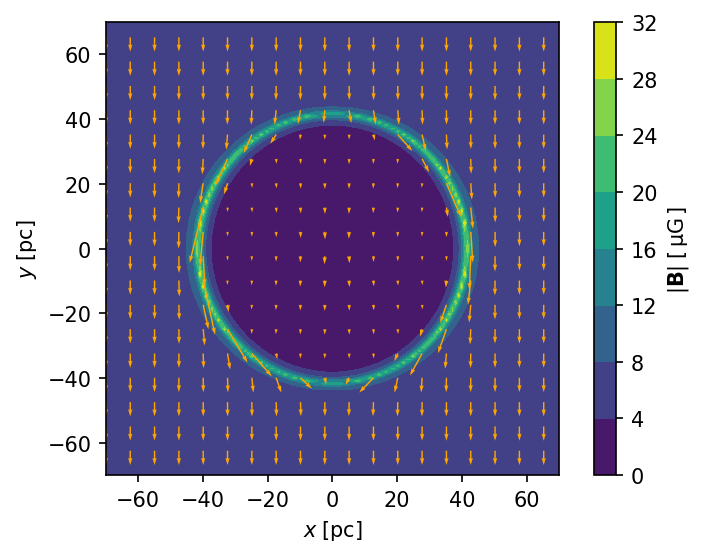

In [6]:
B_uniform = img_snrs.fields.SNRUniformMagneticField(grid,
                                                    parameters={'B':4*u.microgauss, 
                                                                'beta':0*u.deg, 
                                                                'gamma':90*u.deg})
b_unif = B_uniform.get_data(dependencies={img_snrs.fields.SNRThermalElectrons: ne_field})
b_unif_list = [b_unif[:,:,:,i] for i in range(3)]
shell.visualization.plot_vector_xy(grid, b_unif_list, skip=8);

As one can see, the shell properties are inherited from the electron density field.

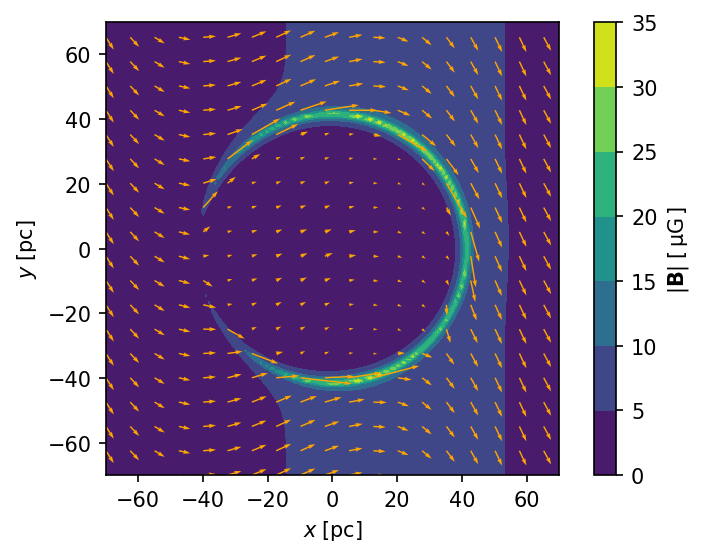

In [7]:
B_helical = img_snrs.fields.SNRSimpleHelicalMagneticField(
    grid, parameters={'B':4*u.microgauss, 'period': 70*u.pc,
                      'alpha':-40*u.deg, 'beta':0*u.deg, 'gamma':20*u.deg})
b_hel = B_helical.get_data(dependencies={img_snrs.fields.SNRThermalElectrons: ne_field})
b_hel_list = [b_hel[...,i] for i in range(3)]
shell.visualization.plot_vector_xy(grid, b_hel_list, skip=8);

### Cosmic ray electrons

Formally, there should be an IMAGINE Field for the cosmic rays. There is, however, still no agreement on what is the adequate generic format for the cosmic ray field base class (due to the requirement of specifying the energy spectrum as well as the spatial distribution). So, we define a provisional base class within the `imagine_snrs` package.

We consider three possibilities of CR electrons, described below.


#### Constant CR

If we assume that the diffusion timescale is much smaller than the other timescales in the problem, the CRe are approximately constant within the box

In [8]:
CR_constant = img_snrs.fields.ConstantCosmicRayElectrons(grid, 
                                                         parameters={'cr_energy': 1*u.GeV,
                                                                     'ncre': 0.01*u.cm**-3})
ncr_const = CR_constant.get_data()

In [9]:
ncr_const[0,0,0,0]

<Quantity 0.01 1 / cm3>


#### CR in energy equipartition with the magnetic field 

Another simple, but sound assumption

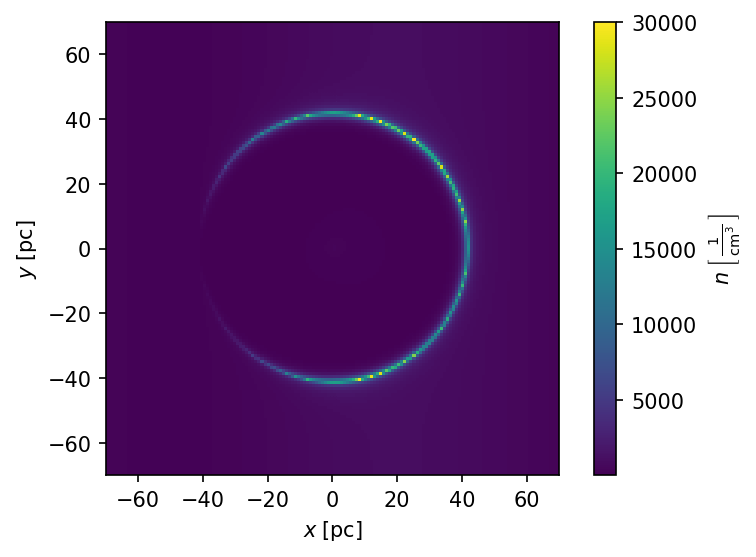

In [10]:
CR_equip = img_snrs.fields.EquipartitionCosmicRayElectrons(grid, 
                                                           parameters={'cr_energy': 1*u.GeV,
                                                                          'Ecr_Em': 1})
ncr_equip = CR_equip.get_data(dependencies={'magnetic_field': b_hel})

shell.visualization.plot_scalar_xy(grid, ncr_equip[...,0]);

#### CRe tracking thermal electorns 

Finally, for completeness, we consider the case where the accelaration process leads to CRe overdensities in the densest parts of the shell. A rough approximation to this is assuming that the CRe density is proportional to the thermal electron density.

In [11]:
CR_tracking = img_snrs.fields.TrackingCosmicRayElectrons(grid, 
                                                         parameters={'cr_energy': 1*u.GeV,
                                                                     'ncre_nte': 1})
ncr_track = CR_tracking.get_data(dependencies={'thermal_electron_density': ne_data})

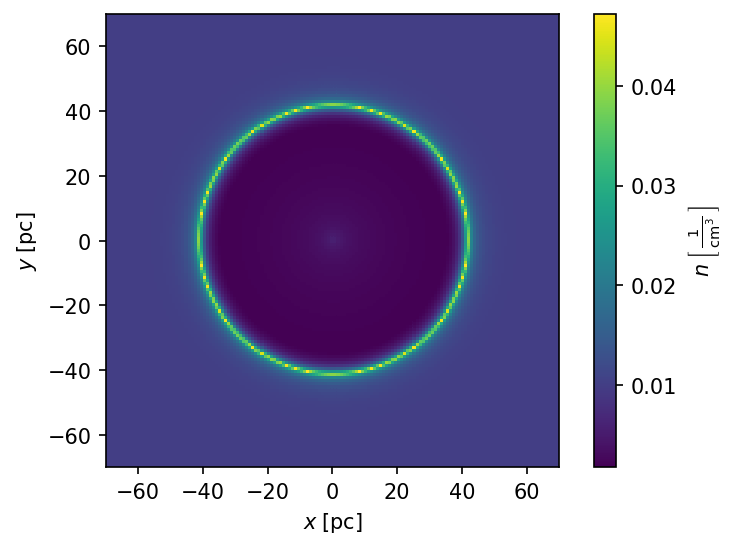

In [12]:
shell.visualization.plot_scalar_xy(grid, ncr_track[...,0]);

## Simulator class

Finally, it is necessary show IMAGINE how to convert the `Fields` into `Observables` using a [Simulator](https://imagine-code.readthedocs.io/en/latest/components.html#simulators) class (tutorial [here](https://imagine-code.readthedocs.io/en/latest/tutorial_simulator.html)).

I have implemented a simple simulator based on the contents of the original `observables` module within the `shell` package. It integrates over the z-direction of the original cartesian grid. The image in the final 2D array is assumed to be centred in the same way as the original image data, and the array obtained from the integration is interpolated/scaled into the same layout as the measured image (accounting for the `distance` which is specified when creating the simulator).

I have included the possibility of specifying a finite beam size using the keyword parameter `beam_kernel_sd`, which should contain the standard deviation associated with the gaussian kernel used in the convolution (in number of pixels).

In [13]:
simulator = img_snrs.simulators.SimpleSynchrotron(measurements, 
                                                  distance=11.3*u.kpc, 
                                                  gamma=3., 
                                                  beam_kernel_sd=2.5)

In [14]:
simulations = simulator([ne_field, CR_constant, B_helical])

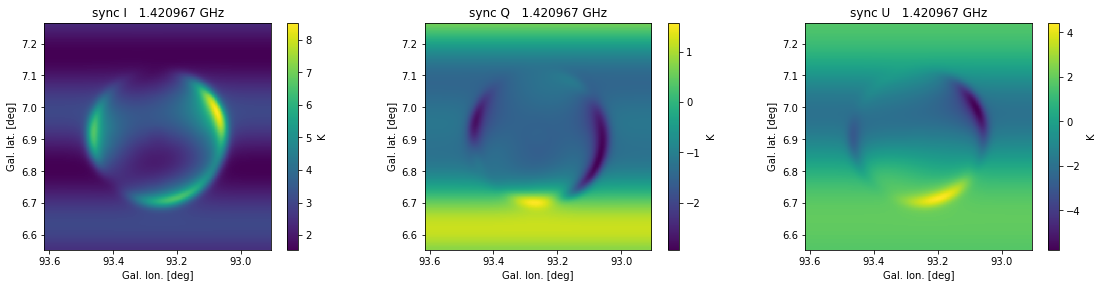

In [15]:
plt.figure(figsize=(16,4))
simulations.show()
plt.tight_layout()

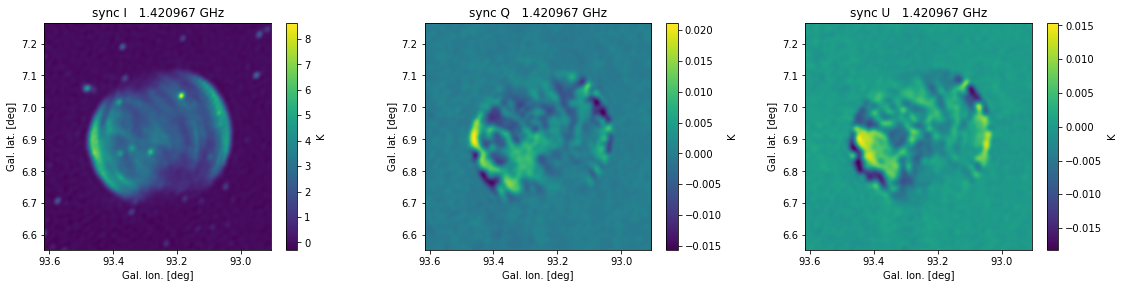

In [16]:
plt.figure(figsize=(16,4))
measurements.show()
plt.tight_layout()

/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


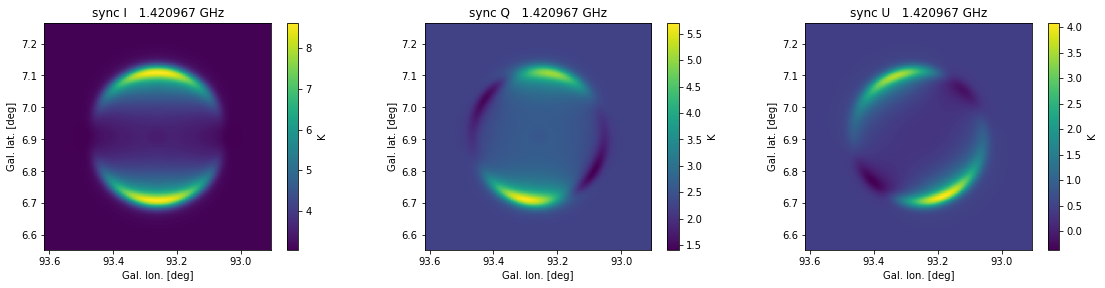

In [17]:
simulations = simulator([ne_field, CR_constant, B_uniform])
plt.figure(figsize=(16,4))
simulations.show()
plt.tight_layout()

## Field factories (and priors)

In the following, I exemplify how to prepare `FieldFactory` objects and specify active/inactive parameters, default values and priors.

In [18]:
from imagine.fields import FieldFactory
from imagine.priors import FlatPrior, GaussianPrior

te_factory = FieldFactory(grid=grid,
                                field_class=img_snrs.fields.SNRThermalElectrons,
                                active_parameters=(),#'initial_electron_density', 'shell_radius'),
                                default_parameters={'initial_electron_density': 0.01*u.cm**-3,
                                                    'shell_V0':0.0153*u.pc/u.yr, 
                                                    'shell_a': 1.3, 
                                                    'shell_b': 10,
                                                    'elapsed_time': 1300*u.yr,
                                                    'shell_radius': 35*u.pc},
                                priors={'initial_electron_density': FlatPrior(1e-4, 10, u.cm**-3),
                                        'shell_V0': FlatPrior(1e-3, 0.1, u.pc/u.yr),
                                        'shell_a': FlatPrior(0.5, 2), 
                                        'shell_b': FlatPrior(1, 50), 
                                        'elapsed_time': FlatPrior(500, 3000, u.yr),
                                        'shell_radius': FlatPrior(10, 200, u.pc)})

B_factory  = FieldFactory(grid=grid,
                                field_class=img_snrs.fields.SNRUniformMagneticField,
                                active_parameters =('B', 'beta', 'gamma'),
                                default_parameters={'B': 2*u.microgauss, 
                                                   'beta': 0*u.deg,
                                                   'gamma': 0*u.deg},
                                 priors={'B': FlatPrior(0, 10, u.microgauss),
                                         'beta': FlatPrior(-90, 90, u.deg),
                                         'gamma': FlatPrior(-180, 180, u.deg)})
B_helical_factory  = FieldFactory(grid=grid,
                                  field_class=img_snrs.fields.SNRSimpleHelicalMagneticField,
                                  active_parameters =('B', 'alpha', 'beta', 'gamma', 'period'),
                                  default_parameters={'B': 2*u.microgauss,
                                                      'alpha': 0*u.deg,
                                                      'beta': 0*u.deg,
                                                      'gamma': 0*u.deg,
                                                      'period': 70*u.pc},
                                  priors={'B': FlatPrior(0, 10, u.microgauss),
                                          'alpha': FlatPrior(-180, 180, u.deg), 
                                          'beta': FlatPrior(-90, 90, u.deg), 
                                          'gamma': FlatPrior(-180, 180, u.deg),
                                          'period': FlatPrior(10,70, u.pc)})

CR_factory = FieldFactory(grid=grid, 
                          field_class=img_snrs.fields.EquipartitionCosmicRayElectrons,
                          active_parameters=(),
                          default_parameters={'cr_energy': 1*u.GeV,
                                              'Ecr_Em': 1},
                          priors={'Ecr_Em': GaussianPrior(mu=1, sigma=0.1, 
                                                                xmin=1e-2, xmax=10)})

## IMAGINE pipeline

Now we are very close to run this using the IMAGINE pipeline. We first need to initialize the likelihood object. As we are not using stochastic fields, we can use the `SimpleLikelihood` class.

In [19]:
likelihood = img.likelihoods.SimpleLikelihood(measurements)

We have all the ingredients to prepare our pipeline! Some intial tests seem to indicate a possible incompatibility between `numba` and `pyMultiNest`. So, we will instead use the `UltraNest` pipeline (which is slightly slower, but more robust).

In [20]:
pipeline = img.pipelines.UltranestPipeline(run_directory='../runs/test_uniform_field',
                                           simulator=simulator,
                                           factory_list=[B_factory, CR_factory, te_factory],
                                           show_progress_reports=True,
                                           likelihood=likelihood)
pipeline.sampling_controllers={'min_num_live_points':150}


In this initial test, we only try to fit a uniform field, and hopefully get its "best fit" orientation and amplitude. We can inspect *all* active parameters doing:

In [21]:
pipeline.active_parameters

('SNR_unif_magnetic_field_B',
 'SNR_unif_magnetic_field_beta',
 'SNR_unif_magnetic_field_gamma')

Below a quick test and timing of the complete likelihood function:

In [22]:
pipeline.test()

Sampling centres of the parameter ranges.
	Evaluating point: [5.0, 0.0, 0.0]
	Log-likelihood -8.784360559644592e+23
	Total execution time:  0.9840665142983198 s

Randomly sampling from prior.
	Evaluating point: [   3.02332573  -63.58393965 -146.75810588]
	Log-likelihood -5.027916809843649e+22
	Total execution time:  0.9802333153784275 s

Randomly sampling from prior.
	Evaluating point: [  1.86260211 -27.79906913 -37.16370928]
	Log-likelihood -1.080018540299683e+21
	Total execution time:  0.9910418214276433 s

Average execution time: 0.9851138837014636 s


<Quantity 0.98511388 s>

It looks like everything is working. A few points, though:

* The log-likelihood values are dangerously small. I will rescale the likelihoods from this point on to avoid that the sampler misbehaves due to underflows.
* This is still not fast enough to run practically on a notebook. A couple of scripts: prepare.py and run.py were added to the 'runs' directory.

Now, I will show how to load and examine a previously completed run.

## Results of IMAGINE pipeline runs

First, we look at a basic case of a uniform initial field, where we only vary the field amplitude and orientation (the latter given by the parameters $\beta$ and $\gamma$). 

In [23]:
pipeline = img.load_pipeline('../runs/uniform_field/')

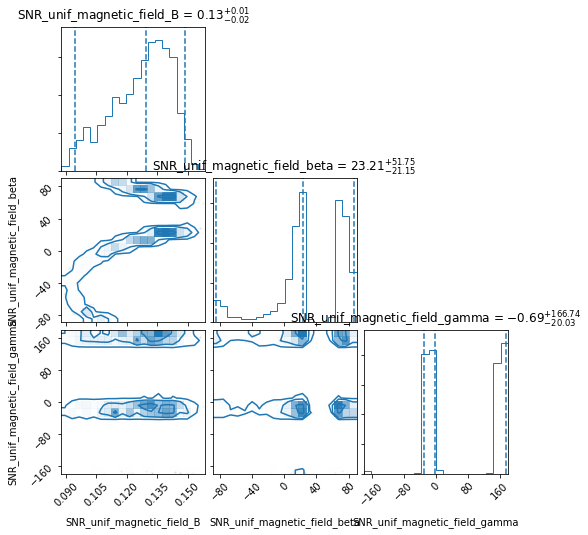

**Evidence report:**

<IPython.core.display.Math object>

In [24]:
pipeline.corner_plot()
plt.show()
pipeline.evidence_report()

The corner plot gives us an idea of the degeneracies in the problem. Let us re-plot the marginal distributions and dig a little bit more of information.

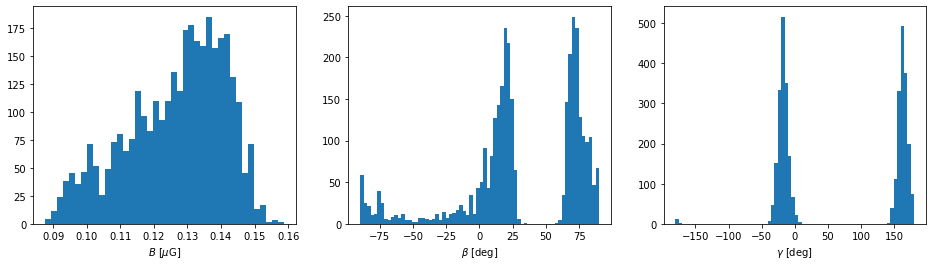

In [25]:
B = pipeline.samples['SNR_unif_magnetic_field_B']
beta = pipeline.samples['SNR_unif_magnetic_field_beta']
gamma = pipeline.samples['SNR_unif_magnetic_field_gamma']

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.hist(B.value, bins=40)
# plt.xlim(0.125,0.15)
plt.xlabel(r'$B$ [$\mu \rm G$]')
plt.subplot(132)
plt.hist(beta.value, bins=70)
# plt.xlim(0,90)
plt.xlabel(r'$\beta$ [deg]')
plt.subplot(133)
plt.hist(gamma.value, bins=70)
# plt.xlim(-50,180)
plt.xlabel(r'$\gamma$ [deg]');

We can see that the angles $\beta\approx 70^\circ$ and $\beta\approx 20^\circ$ are degenerate, as $\gamma\approx -20^\circ$ and $\gamma\approx 160^\circ$.
The best-fit magnitude of the field is more straightforward: $B\approx 0.135\mu\rm G$.

Let us construct a model with these values. To avoid problems, I will use the exact same field factories stored in the pipeline object.

In [26]:
# Check the indices of the field factories
[f.name for f in pipeline.factory_list]

['SNR_unif_magnetic_field', 'constant_CR', 'SNR_magnetic_field']

In [27]:
def show_choice(B=0.135*u.microgauss, beta=20*u.deg, gamma=-20*u.deg):
    B = pipeline.factory_list[0](variables={'beta': beta, 
                                            'gamma': gamma,
                                            'B': 0.135*u.microgauss})
    CR = pipeline.factory_list[1](variables={})
    SNR = pipeline.factory_list[2](variables={})
    simulations = pipeline.simulator([B, CR, SNR])
    plt.figure(figsize=(16,4))
    simulations.show()
    plt.tight_layout()

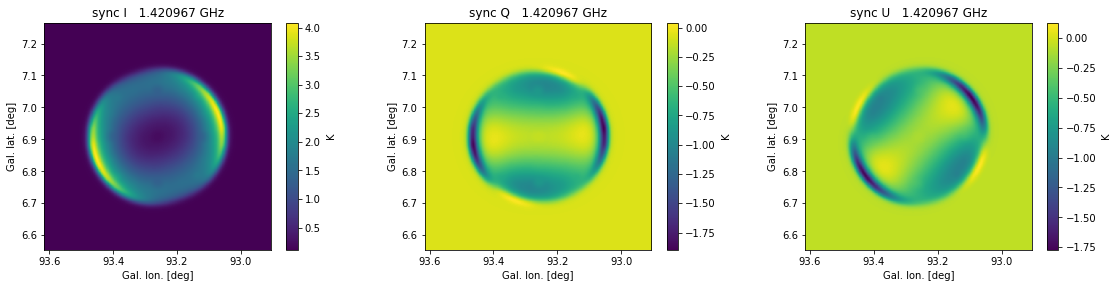

In [28]:
show_choice(beta=20*u.deg, gamma=-20*u.deg)

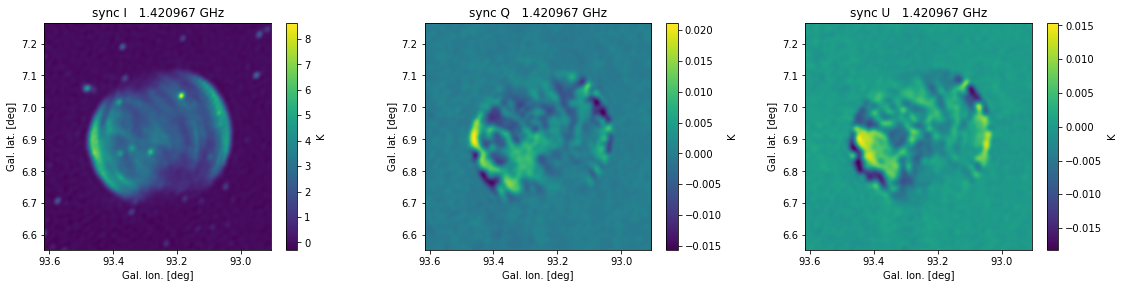

In [29]:
plt.figure(figsize=(16,4))
measurements.show()
plt.tight_layout()

Now let us look at the "simple helical" case (the old helical field in Ivan's draft). 

In [30]:
pipeline_helical = img.load_pipeline('../runs/simple_helical_field/')

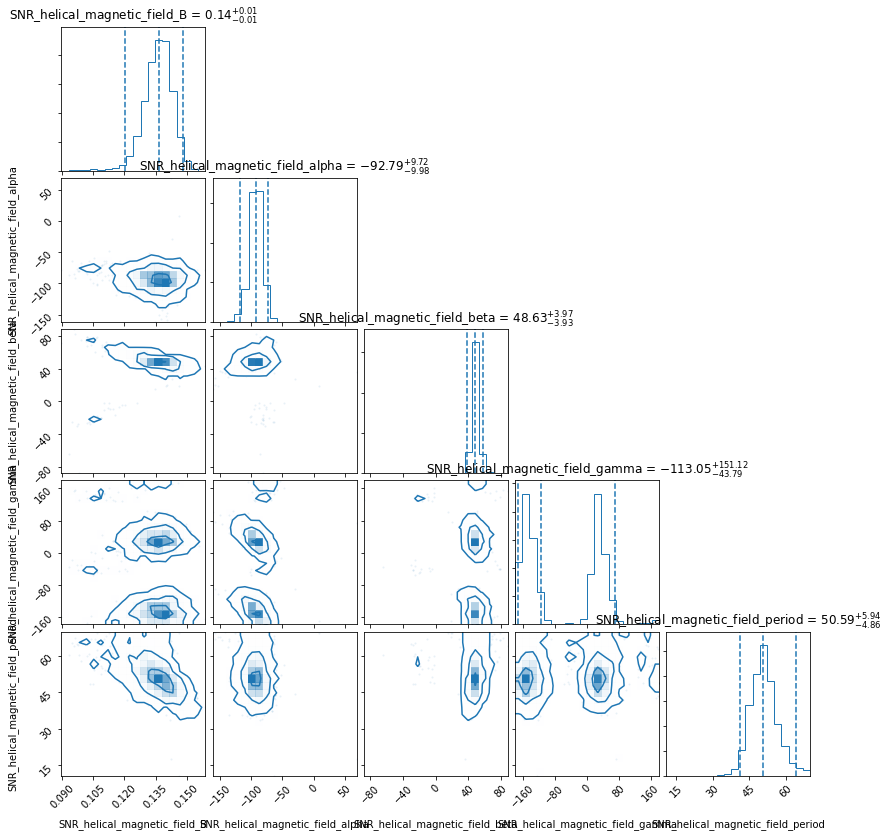

**Evidence report:**

<IPython.core.display.Math object>

In [45]:
pipeline_helical.corner_plot()
plt.show()
pipeline_helical.evidence_report()

Again, we can see the $\gamma$ angle degeneracy. On interesting result is that the best fit *period* parameter seems to be very well defined: $p\approx 50\rm pc$. Likewise, the amplitude of the field is similar to the one found in the uniform case, $B \approx 0.14\mu\rm G$.

One important, and superficially surprising, result is that the *Bayesian evidence* is smaller for this model. This means that, on face value, the *uniform model* performs better. The reason for this may be the two extra parameters introduced here (which are automatically penalised by this procedure). 

One must bear in mind, however, that the shell parameters and cosmic ray electron density were fixed. Once those the inference is re-run with those free, there could be significant changes in the evidence values.

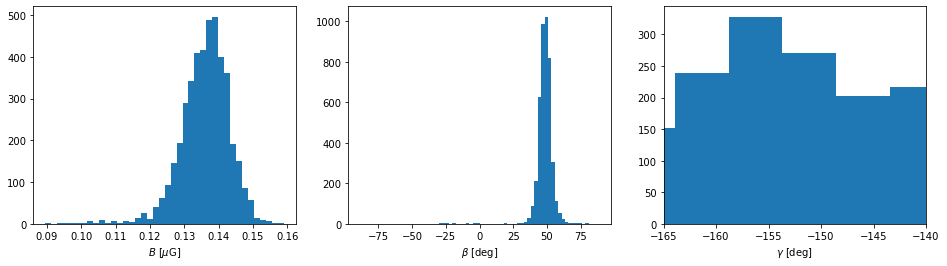

In [41]:
B = pipeline_helical.samples['SNR_helical_magnetic_field_B']
beta = pipeline_helical.samples['SNR_helical_magnetic_field_beta']
gamma = pipeline_helical.samples['SNR_helical_magnetic_field_gamma']

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.hist(B.value, bins=40)
# plt.xlim(0.125,0.15)
plt.xlabel(r'$B$ [$\mu \rm G$]')
plt.subplot(132)
plt.hist(beta.value, bins=70)
# plt.xlim(0,90)
plt.xlabel(r'$\beta$ [deg]')
plt.subplot(133)
plt.hist(gamma.value, bins=70)
plt.xlim(-165,-140)
plt.xlabel(r'$\gamma$ [deg]');

In [38]:
print('Median and default values:')
for field in pipeline_helical.median_model:
    print(field.name)
    for par, val in field.parameters.items():
        print('\t', par, val)

Median and default values:
SNR_helical_magnetic_field
	 B 0.1366236512264588 uG
	 alpha -92.79209222753765 deg
	 beta 48.62893324746477 deg
	 gamma -113.04920901508216 deg
	 period 50.59206788098017 pc
constant_CR
	 cr_energy 1.0 GeV
	 Ecr_Em 1.0
SNR_magnetic_field
	 initial_electron_density 0.01 1 / cm3
	 shell_V0 0.0153 pc / yr
	 shell_a 1.3
	 shell_b 10.0
	 elapsed_time 1300.0 yr
	 shell_radius 35.0 pc


In [46]:
def show_helical_choice(B=0.1366*u.microgauss, period=50.6*u.pc, 
                        alpha=-92.8*u.deg, beta=48.6*u.deg, gamma=-155*u.deg, ):
    B = pipeline_helical.factory_list[0](variables={'alpha':alpha,
                                                    'beta': beta, 
                                                    'gamma': gamma,
                                                    'period':period,
                                                    'B': B})
    CR = pipeline_helical.factory_list[1](variables={})
    SNR = pipeline_helical.factory_list[2](variables={})
    simulations = pipeline_helical.simulator([B, CR, SNR])
    plt.figure(figsize=(16,4))
    simulations.show()
    plt.tight_layout()

<Figure size 1152x288 with 0 Axes>

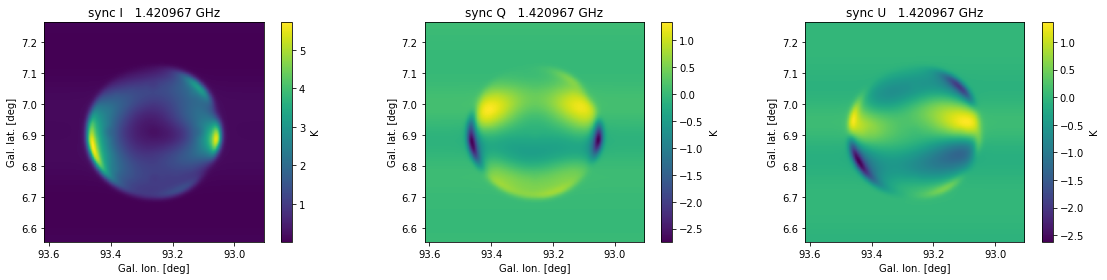

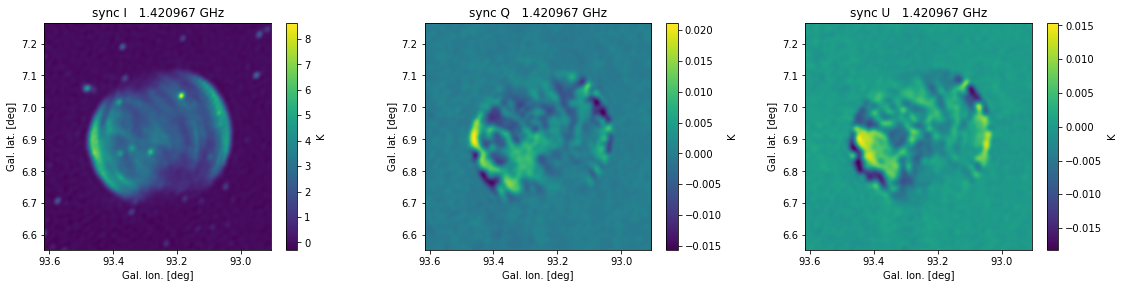

In [44]:
plt.figure(figsize=(16,4))
show_helical_choice()
plt.tight_layout()

plt.figure(figsize=(16,4))
measurements.show()
plt.tight_layout()